In [1]:
from keras import models
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000
import numpy as np 
import pandas as pd
import os 
import soundfile as sf

from make_CFcall_training_data import calculate_snippet_features,make_9number_to_class_converter

Using TensorFlow backend.


In [2]:
# load neural network and weights:
with open('CF_classifier_1jandata_9class.json' ,'r') as model_json:
    n = models.model_from_json(model_json.read())
n.load_weights('CF_classifier1jandata_9class.h5')
n.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

In [3]:
n.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 198, 32)           512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 99, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 98, 16)            1040      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 49, 16)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 297       
Total para

In [4]:
# load audio snippets and calculate features 
labs = pd.read_csv('audio_labels_cleaned.csv')
date_2_folder_paths = {
        '2018-08-16' : os.path.join('audio', '2018-08-16/'),
        '2018-08-18' : os.path.join('audio', '2018-08-18/'),
        '2018-08-19' : os.path.join('audio', '2018-08-19', 'ch1/',)
                        }
path_to_datafolder = os.path.join('/media', 'tbeleyur', 'THEJASVI_DATA_BACKUP_3',
                                  'fieldwork_2018_002', 'horseshoe_bat',
                                  )

all_features = np.zeros((labs.shape[0],200,5))
all_classes = []
all_audio = []
fs = 250000
for i, row in labs.iterrows():
    t_start, t_stop = row['time_start'], row['time_end']
    file_name = os.path.join(path_to_datafolder, 
                             date_2_folder_paths[row['date_recorded']],
                             row['file_name'])
    ch_num = int(row['channel_num'])
    snippet, _ = sf.read(file_name, start=int(t_start*fs), 
                                     stop=int(t_stop*fs))
    num_samples = 50000
    input_snippet = snippet[:,ch_num][:num_samples]
    input_snippet /= np.max(input_snippet)
    all_features[i,:,:] = calculate_snippet_features(input_snippet)
    # max normalise each channel :
    for each_ch in range(5):
        all_features[i,:,each_ch] /= np.max(all_features[i,:,each_ch])

    all_classes.append(str(labs.loc[i,'class_name']))
    all_audio.append(input_snippet)
   

/home/tbeleyur/anaconda2/envs/horseshoebat/lib/python2.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [5]:
layer_outputs = [layer.output for layer in n.layers[:4]]
activation_model = models.Model(inputs=n.input, outputs=layer_outputs)

In [6]:
%matplotlib notebook

In [7]:
ninenum_to_classname = make_9number_to_class_converter()

<IPython.core.display.Javascript object>


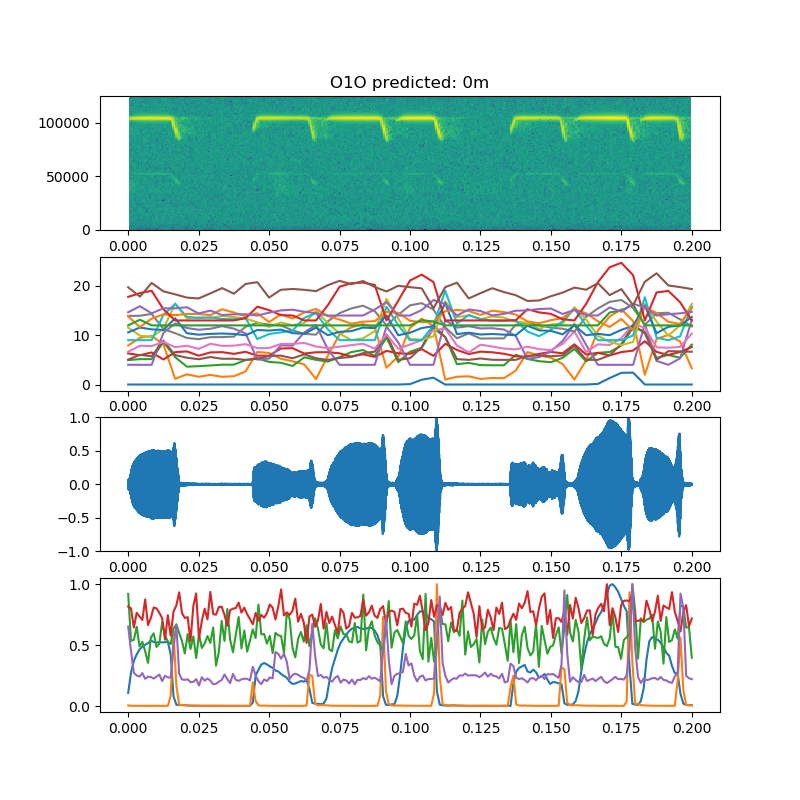

In [32]:
num_ind = int(np.random.choice(xrange(len(all_audio)),1))
activations = activation_model.predict(all_features[num_ind:num_ind+1,:,:])
pred_classnum = int(n.predict_classes(all_features[num_ind:num_ind+1,:,:]))
pred_class = ninenum_to_classname[pred_classnum]
plt.figure(figsize=(8,8))
a0 = plt.subplot(411)
plt.title(all_classes[num_ind] + ' predicted: ' + pred_class )

plt.specgram(all_audio[num_ind], Fs=250000);

plt.subplot(412, sharex=a0)
for each_channel in range(activations[3].shape[2]):
    plt.plot(np.linspace(0,0.2, activations[3].shape[1]),
             activations[3][:,:,each_channel].flatten()*3 + each_channel
              , '-')

plt.subplot(413, sharex=a0)
plt.plot(np.linspace(0,0.2,50000),all_audio[num_ind])
plt.ylim(-1,1)
plt.subplot(414)
for each_ch in range(5):
    plt.plot(np.linspace(0,0.2,200),
             all_features[num_ind,:,each_ch])